Note: this code is adapted from https://www.kaggle.com/roundedup/of-bikes-and-cabs-nyc/notebook

In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import time

## Load the dataset.

In [2]:
# Load the bike dataset.
bike_df = pd.read_csv('201801-citibike-tripdata.csv')

In [3]:
# Print first row of dataset to see example values.
bike_df.head(1)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,196,2018-01-01 00:01:51,2018-01-01 00:05:07,315,South St & Gouverneur Ln,40.703554,-74.006702,259,South St & Whitehall St,40.701221,-74.012342,18534,Subscriber,1997.0,1


In [4]:
# Get all distinct station IDs from the dataset.
station_ids = pd.concat([bike_df['start station id'], bike_df['end station id']]).drop_duplicates()
station_ids.name = 'station_og_id'
station_ids = station_ids.to_frame()
N = len(station_ids)
print '%d stations' % N

767 stations


In [5]:
# Create mapping from original station ID to new station ID.
station_ids.insert(0, 'station_id', range(len(station_ids)))
station_id_map = station_ids.set_index('station_og_id').to_dict('index')
station_id_map = {k: v['station_id'] for k,v in station_id_map.items()}

In [6]:
# Use stations IDs numbered from 0 to N-1.
start_time = time.time()
bike_df['start station id'] = bike_df.transform(lambda trip: station_id_map[trip['start station id']], axis=1)
bike_df['end station id'] = bike_df.transform(lambda trip: station_id_map[trip['end station id']], axis=1)
print 'assign station ID took %.2f seconds' % (time.time() - start_time)

assign station ID took 48.85 seconds


## Compute hourly trip counts for each station.

The hourly distribution is used to estimate the number of arrivals per hour, per station.

The data structure is a N x 24 matrix.

In [7]:
# Compute pickup hour (0-23) for each trip.
bike_df['pickup_hour'] = pd.to_datetime(bike_df['starttime']).dt.hour

In [8]:
def compute_trip_histogram(trip_hours):
    hist, _ = np.histogram(trip_hours, bins=24, range=(0, 24))
    return hist

In [9]:
start_time = time.time()
# Compute arrival data.
trip_hists = bike_df.groupby(['start station id'])['pickup_hour'].apply(compute_trip_histogram)
trip_count_data = defaultdict(lambda: np.zeros(24))  # default value for dest-only stations
trip_count_data.update(trip_hists.to_dict())
# Convert to numpy array.
trip_count_data = np.array([trip_count_data[i] for i in range(N)])
# Average over 31 days. Round to nearest int.
trip_count_data = np.rint(trip_count_data / 31.0)
print 'Computing arrival counts took %.2f seconds' % (time.time() - start_time)

Computing arrival counts took 0.46 seconds


In [10]:
trip_count_data.shape

(767, 24)

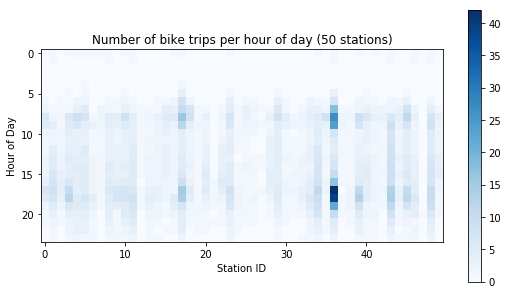

In [11]:
# Plot hourly trip histogram for a subset of stations (hard to see all 767 stations).
subset_size = 50
plt.figure(figsize=(9, 5)) 
plt.title('Number of bike trips per hour of day (%d stations)' % subset_size)
plt.imshow(trip_count_data.transpose()[:, :subset_size], cmap=cm.Blues) 
plt.colorbar()
plt.xlabel('Station ID')
plt.ylabel('Hour of Day')
plt.show()

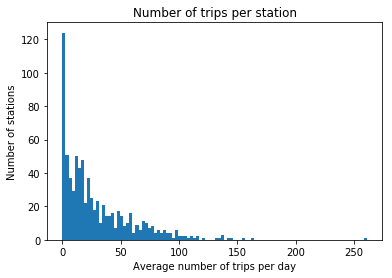

In [12]:
# Plot distribution of daily trips per station.
trips_per_station = trip_count_data.sum(axis=1)  # sum over hours
plt.title('Number of trips per station')
plt.ylabel('Number of stations')
plt.xlabel('Average number of trips per day')
plt.hist(trips_per_station, bins=100)
plt.show()

**Save trip_data to file**

In [13]:
np.save('tripCountData', trip_count_data.astype(int))

**Example usage**

In [14]:
# Load the trip data from file.
trip_count_data = np.load('tripCountData.npy')

# Example: number of trips at station 10 during time 17:00
trip_count_data[10][17]

7

In [15]:
trip_count_data[571][0]

0

### Compute probability of trips between each station pair.

In [16]:
def compute_dest_histogram(trips):
    # Return 24xN histogram.
    hist = np.zeros((24, N))
    for row in trips.itertuples():
        hist[int(row[1]), int(row[2])] += 1
    return [hist]  # return type must be hashable

In [17]:
start_time = time.time()
# Compute hourly ditributions.
dest_distr = bike_df.groupby('start station id')['pickup_hour', 'end station id'].apply(compute_dest_histogram)
dest_distr = {k: v[0] for k,v in dest_distr.to_dict().items()}
destination_distr = defaultdict(lambda: np.zeros((24, N)))  # default value for dest-only stations
destination_distr.update(dest_distr)
# Convert to numpy array.
destination_distr = np.array([destination_distr[i] for i in range(N)])
print 'compute_dest_histogram took %.2f seconds' % (time.time() - start_time)

compute_dest_histogram took 3.24 seconds


In [18]:
# Print stations which are destinations only.
num_dest_only = 0
for i in range(N):
    if i not in dest_distr.keys():
        num_dest_only += 1
        print i
print '%d stations are destinations only' % num_dest_only

763
764
765
766
4 stations are destinations only


In [19]:
destination_distr.shape

(767, 24, 767)

In [20]:
# Compute destination probabilities.
dest_probabilities = np.zeros(destination_distr.shape)
for i in range(N):  # station i
    for j in range(destination_distr.shape[1]):  # timeframe j
        total_in_timeframe = destination_distr[i, j, :].sum()
        if total_in_timeframe > 0:
            dest_probabilities[i, j, :] = destination_distr[i, j, :] / total_in_timeframe

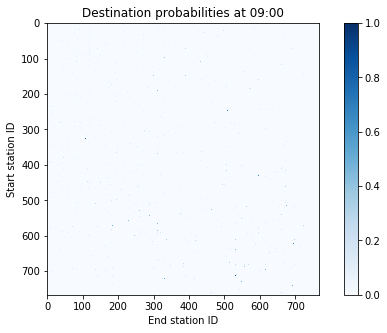

In [21]:
# Visualize trip probablities between station pairs.
hour_of_day = 9
plt.figure(figsize=(9, 5)) 
plt.title('Destination probabilities at %02d:00' % hour_of_day)
plt.imshow(dest_probabilities[:, hour_of_day, :], cmap=cm.Blues) 
plt.colorbar()
plt.xlabel('End station ID')
plt.ylabel('Start station ID')
plt.show()

In [22]:
# Visualize trip probabilities between stations for one hour of the day.
hour_of_day = 9

start_station_loc_map = (bike_df[['start station id', 'start station longitude', 'start station latitude']]
        .drop_duplicates().rename(columns={'start station id': 'station id', 'start station longitude': 'long', 'start station latitude': 'lat'}))
end_station_loc_map = (bike_df[['end station id', 'end station longitude', 'end station latitude']]
        .drop_duplicates().rename(columns={'end station id': 'station id', 'end station longitude': 'long', 'end station latitude': 'lat'}))
station_loc_map = pd.concat([start_station_loc_map, end_station_loc_map]).set_index('station id').to_dict('index')
station_loc_map = {k: (v['long'], v['lat']) for k, v in station_loc_map.items()}

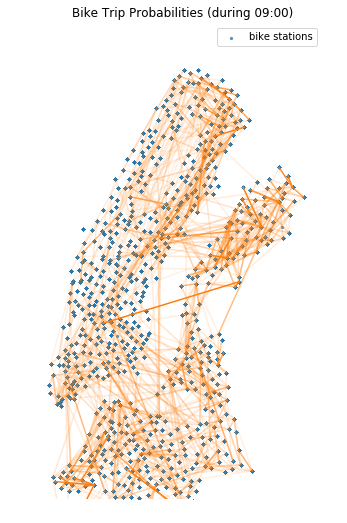

In [23]:
plt.figure(figsize=(5, 5*1.75))
plt.title('Bike Trip Probabilities (during %02d:00)' % hour_of_day)
# Plot stations.
plt.scatter(bike_df['start station longitude'], bike_df['start station latitude'],s=5,alpha=0.7,label='bike stations')
# Plot lines between stations.
for start_id in range(N):
    for end_id in range(N):
        if dest_probabilities[start_id, hour_of_day, end_id] > 0.1:
            plt.plot([station_loc_map[start_id][0], station_loc_map[end_id][0]],
                     [station_loc_map[start_id][1], station_loc_map[end_id][1]],
                     color='#ff7f0e',
                     alpha=dest_probabilities[start_id, hour_of_day, end_id])
# Define extent of axes.
plt.axis([-74.02,-73.90,40.67,40.83])
plt.legend()
plt.axis('off')
plt.show()

**Save destination data to file**

In [24]:
np.save('destinationP', dest_probabilities)

**Example usage**

In [25]:
# Load the destination probabilities from file.
dest_probabilities = np.load('destinationP.npy')

# Example: choose random destination from station 54 during 17:00
random_dest = np.random.choice(range(N), p=dest_probabilities[54][17])
print 'Station %d was randomly selected as the destination (probability=%.3f).' % (
    random_dest, dest_probabilities[54][17][random_dest])

Station 355 was randomly selected as the destination (probability=0.032).


In [26]:
dest_probabilities[571][0].sum()

0.0

### Compute average trip duration for every pair of stations.

Note: the duration of trip (s,t) is not necessarily the same as the duration of trip (t,s). For example, station s can be at the top of a hill, resulting in shorter trips _from_ s but longer trips _to_ s.

In [27]:
# Initialize NxN matrix of trip durations.
# Use NaN as the default value (to avoid confusion with 0).
trip_duration = np.zeros((N, N))
trip_duration[:, :] = np.nan

In [28]:
# Compute trip durations for all pairs of stations in the dataset.
avg_duration = bike_df.groupby(['start station id', 'end station id'])['tripduration'].mean()
# Convert seconds to minutes.
avg_duration = avg_duration / 60.0
# Convert to matrix.
for idx, duration in avg_duration.iteritems():
    trip_duration[idx] = duration

In [29]:
# The dataset does not have trips between every pair of stations.
# Count the number of station pairs which have trip duration data.
pairs_with_trip_duration = np.count_nonzero(~np.isnan(trip_duration))
print 'Trip duration data for %d (%.2f%%) stations pairs.' % (
    pairs_with_trip_duration, float(pairs_with_trip_duration) / (N*N) * 100)

Trip duration data for 108319 (18.41%) stations pairs.


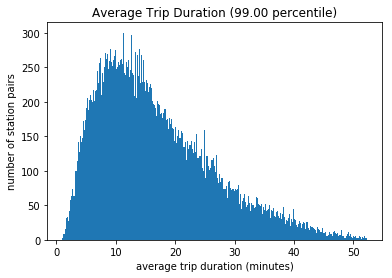

In [30]:
# Visualize percentile of data.
percentile = 99
unique = trip_duration[~np.isnan(trip_duration)]
unique = unique[unique < np.percentile(unique, percentile)]

plt.title('Average Trip Duration (%0.2f percentile)' % percentile)
plt.xlabel('average trip duration (minutes)')
plt.ylabel('number of station pairs')
plt.hist(unique, bins=1000)
plt.show()

**Save duration data to file**

In [31]:
np.save('Durations', trip_duration)

**Example usage**

In [32]:
# Load duration data from file.
trip_duration = np.load('Durations.npy')

# Example: average trip duration between station 50 and station 200
print trip_duration[50][200]
# Example: average trip duration between station 200 and station 50
print trip_duration[200][50]

18.6595238095
4.29047619048
